In [84]:
# so modules are automatically reloaded when they are changed
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from utils.results_utils import *
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn

from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from scipy.stats import linregress, pearsonr
from matplotlib.patches import Patch


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load results

In [ ]:
data = 'CheXpert-v1.0-small'
wandb_name = ''

method = 'GroupDRO'
with open(f'processed_results/{data}_{method}_{wandb_name}_train_val_results_dict.pkl','rb') as f:
    train_val_dict = pickle.load(f)
with open(f'processed_results/{data}_{method}_{wandb_name}_test_results_dict.pkl', 'rb') as f:
    test_results_dict = pickle.load(f)
with open(f'processed_results/{data}_{method}_{wandb_name}_loss_results_dict.pkl', 'rb') as f:
    loss_dict = pickle.load(f)

method = 'resampling'
with open(f'processed_results/{data}_{method}_{wandb_name}_test_results_dict.pkl', 'rb') as f:
    resampling_test_results_dict = pickle.load(f)

method = 'DomainInd'
with open(f'processed_results/{data}_{method}_{wandb_name}_test_results_dict.pkl', 'rb') as f:
    DomainInd_test_results_dict = pickle.load(f)

method = 'CFair_'
with open(f'processed_results/{data}_{method}_{wandb_name}_test_results_dict.pkl', 'rb') as f:
    cfair_test_results_dict = pickle.load(f)

In [86]:
# reorder dicts
for dictionary in [train_val_dict, test_results_dict, loss_dict]:
    if 'baseline' in dictionary.keys():
        keys_order = ['baseline', 'SY', 'AY'] + [k for k in dictionary if k not in {'baseline', 'SY', 'AY'}]
    else:
        keys_order = ['SY', 'AY'] + [k for k in dictionary if k not in {'SY', 'AY'}]

    reordered_dict = {k: dictionary[k] for k in keys_order}
    dictionary.clear()
    dictionary.update(reordered_dict)

In [87]:
random_seed_folders = ['42','43','44']
loss_fn = nn.BCEWithLogitsLoss()

# Overall test results

gDRO

In [88]:
# get mean and std over 3 random seeds
mean_test_results_dict = {}
for key in test_results_dict.keys():
    mean_test_results_dict[key] = {}
    all_overall_test_results = pd.concat([test_results_dict[key][x]['overall_test_results'].T for x in test_results_dict[key].keys()])
    mean_std = all_overall_test_results.apply(pd.to_numeric).describe().loc[['mean', 'std']]
    mean_test_results_dict[key]['overall_test_results'] = mean_std

overall_results_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['mean'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T
overall_std_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['std'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T

overall_results_df.columns = ['Accuracy','AUC','Precision','Recall']
overall_results_df.round(3) 
overall_std_df.columns = ['Accuracy','AUC','Precision','Recall']

baseline_row = overall_results_df.loc['baseline']
baseline_row_df = baseline_row.to_frame().T
baseline_std_row = overall_std_df.loc['baseline']
baseline_std_row_df = baseline_std_row.to_frame().T

overall_results_df.astype(str) + ' ± ' + overall_std_df.astype(str)

Accuracy            AUC      Precision         Recall
baseline      0.659 ± 0.007   0.74 ± 0.002  0.622 ± 0.007  0.811 ± 0.034
SY            0.675 ± 0.018   0.75 ± 0.029  0.641 ± 0.013  0.795 ± 0.024
AY            0.723 ± 0.022   0.794 ± 0.02  0.703 ± 0.021  0.774 ± 0.036
Artefact      0.671 ± 0.041  0.734 ± 0.044  0.643 ± 0.035  0.769 ± 0.041
AY_8          0.726 ± 0.016  0.811 ± 0.007  0.691 ± 0.014  0.815 ± 0.033
Sex           0.679 ± 0.021  0.756 ± 0.007  0.646 ± 0.033  0.801 ± 0.052
SY_8          0.689 ± 0.004  0.743 ± 0.011  0.654 ± 0.012  0.801 ± 0.029
Y             0.671 ± 0.015  0.749 ± 0.016    0.63 ± 0.02  0.832 ± 0.041
noisy_AY_001  0.725 ± 0.006   0.81 ± 0.008  0.696 ± 0.026  0.806 ± 0.083
noisy_AY_005  0.728 ± 0.008  0.792 ± 0.008   0.69 ± 0.024  0.831 ± 0.044
noisy_AY_010  0.725 ± 0.011    0.8 ± 0.016  0.682 ± 0.013  0.843 ± 0.004
noisy_AY_025  0.701 ± 0.027   0.778 ± 0.02  0.664 ± 0.033   0.82 ± 0.033
noisy_AY_050  0.695 ± 0.017   0.75 ± 0.025   0.66 ± 0.023  0.807 ± 0.071
Random        0.688 ± 0.013  0.757 ± 0.015  0.663 ± 0.003  0.765 ± 0.042
Majority       0.721 ± 0.01  0.792 ± 0.015  0.699 ± 0.003  0.775 ± 0.036
YAS           0.705 ± 0.013  0.763 ± 0.032  0.681 ± 0.023  0.777 ± 0.103

Resampling

In [89]:
mean_test_results_dict = {}
for key in resampling_test_results_dict.keys():
    mean_test_results_dict[key] = {}
    all_overall_test_results = pd.concat([resampling_test_results_dict[key][x]['overall_test_results'].T for x in resampling_test_results_dict[key].keys()])
    mean_std = all_overall_test_results.apply(pd.to_numeric).describe().loc[['mean', 'std']]
    mean_test_results_dict[key]['overall_test_results'] = mean_std
resampling_overall_results_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['mean'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T
resampling_overall_std_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['std'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T

resampling_overall_results_df.columns = ['Accuracy','AUC','Precision','Recall']
resampling_overall_results_df.round(3) 
resampling_overall_std_df.columns = ['Accuracy','AUC','Precision','Recall']

resampling_overall_results_df = pd.concat([baseline_row_df, resampling_overall_results_df], axis=0)
resampling_overall_std_df = pd.concat([baseline_std_row_df, resampling_overall_std_df], axis=0)

resampling_overall_results_df.astype(str) + ' ± ' + resampling_overall_std_df.astype(str)

Accuracy            AUC      Precision         Recall
baseline      0.659 ± 0.007   0.74 ± 0.002  0.622 ± 0.007  0.811 ± 0.034
Artefact      0.668 ± 0.008  0.731 ± 0.004  0.636 ± 0.014  0.788 ± 0.025
AY            0.688 ± 0.029  0.771 ± 0.031  0.652 ± 0.028  0.805 ± 0.011
AY_8          0.709 ± 0.016  0.779 ± 0.006  0.686 ± 0.044  0.786 ± 0.093
Sex           0.643 ± 0.037  0.708 ± 0.038  0.615 ± 0.021   0.756 ± 0.09
SY            0.654 ± 0.014  0.736 ± 0.022  0.618 ± 0.015   0.81 ± 0.014
SY_8          0.633 ± 0.057  0.697 ± 0.054  0.607 ± 0.048  0.755 ± 0.098
Y              0.67 ± 0.018  0.742 ± 0.012  0.638 ± 0.018  0.786 ± 0.007
noisy_AY_001   0.695 ± 0.01   0.768 ± 0.02  0.664 ± 0.021  0.796 ± 0.041
noisy_AY_005  0.701 ± 0.015  0.776 ± 0.014  0.657 ± 0.017  0.843 ± 0.009
noisy_AY_010  0.692 ± 0.007  0.766 ± 0.027  0.658 ± 0.016    0.8 ± 0.034
noisy_AY_025  0.677 ± 0.012  0.752 ± 0.011  0.654 ± 0.006  0.754 ± 0.074
noisy_AY_050  0.688 ± 0.018   0.76 ± 0.011  0.649 ± 0.018  0.821 ± 0.004
Random        0.652 ± 0.013  0.725 ± 0.012  0.631 ± 0.031   0.75 ± 0.089
Majority      0.692 ± 0.022  0.763 ± 0.023   0.671 ± 0.04   0.763 ± 0.04
YAS           0.698 ± 0.019  0.767 ± 0.009  0.666 ± 0.018  0.793 ± 0.022

DomainInd

In [90]:
mean_test_results_dict = {}
for key in DomainInd_test_results_dict.keys():
    mean_test_results_dict[key] = {}
    all_overall_test_results = pd.concat([DomainInd_test_results_dict[key][x]['overall_test_results'].T for x in DomainInd_test_results_dict[key].keys()])
    mean_std = all_overall_test_results.apply(pd.to_numeric).describe().loc[['mean', 'std']]
    mean_test_results_dict[key]['overall_test_results'] = mean_std
DomainInd_overall_results_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['mean'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T
DomainInd_overall_std_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['std'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T

DomainInd_overall_results_df.columns = ['Accuracy','AUC','Precision','Recall']
DomainInd_overall_results_df.round(3) 
DomainInd_overall_std_df.columns = ['Accuracy','AUC','Precision','Recall']

DomainInd_overall_results_df = pd.concat([baseline_row_df, DomainInd_overall_results_df], axis=0)
DomainInd_overall_std_df = pd.concat([baseline_std_row_df, DomainInd_overall_std_df], axis=0)

DomainInd_overall_results_df.astype(str) + ' ± ' + DomainInd_overall_std_df.astype(str)

Accuracy            AUC      Precision         Recall
baseline     0.659 ± 0.007   0.74 ± 0.002  0.622 ± 0.007  0.811 ± 0.034
Artefact     0.747 ± 0.011  0.811 ± 0.023   0.719 ± 0.01  0.811 ± 0.036
A_4          0.748 ± 0.022  0.827 ± 0.005  0.713 ± 0.035  0.833 ± 0.038
Sex          0.655 ± 0.014   0.72 ± 0.027    0.62 ± 0.01  0.801 ± 0.036
S_4          0.635 ± 0.037  0.721 ± 0.059   0.603 ± 0.02  0.781 ± 0.095
AS           0.734 ± 0.008  0.816 ± 0.014  0.704 ± 0.037  0.817 ± 0.083
Random       0.658 ± 0.018  0.715 ± 0.015  0.628 ± 0.016    0.78 ± 0.01
Majority     0.541 ± 0.015  0.611 ± 0.027  0.539 ± 0.011  0.558 ± 0.072
noisy_A_001  0.707 ± 0.048  0.779 ± 0.036  0.681 ± 0.045  0.782 ± 0.038
noisy_A_005  0.673 ± 0.007  0.748 ± 0.007  0.648 ± 0.017   0.76 ± 0.082
noisy_A_010  0.668 ± 0.019  0.749 ± 0.031  0.636 ± 0.024   0.793 ± 0.05
noisy_A_025  0.643 ± 0.033   0.723 ± 0.04  0.608 ± 0.023  0.801 ± 0.044
noisy_A_050  0.667 ± 0.008  0.739 ± 0.007  0.634 ± 0.003   0.79 ± 0.045

CFair

In [91]:
mean_test_results_dict = {}
for key in cfair_test_results_dict.keys():
    mean_test_results_dict[key] = {}
    all_overall_test_results = pd.concat([cfair_test_results_dict[key][x]['overall_test_results'].T for x in cfair_test_results_dict[key].keys()])
    mean_std = all_overall_test_results.apply(pd.to_numeric).describe().loc[['mean', 'std']]
    mean_test_results_dict[key]['overall_test_results'] = mean_std
cfair_overall_results_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['mean'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T
cfair_overall_std_df = pd.DataFrame(pd.concat([mean_test_results_dict[model]['overall_test_results'].loc['std'] for model in mean_test_results_dict.keys()],axis=1,keys=mean_test_results_dict.keys()).round(3)).T

cfair_overall_results_df.columns = ['Accuracy','AUC','Precision','Recall']
cfair_overall_results_df.round(3) 
cfair_overall_std_df.columns = ['Accuracy','AUC','Precision','Recall']

cfair_overall_results_df = pd.concat([baseline_row_df, cfair_overall_results_df], axis=0)
cfair_overall_std_df = pd.concat([baseline_std_row_df, cfair_overall_std_df], axis=0)

cfair_overall_results_df.astype(str) + ' ± ' + cfair_overall_std_df.astype(str)

Accuracy            AUC      Precision         Recall
baseline     0.659 ± 0.007   0.74 ± 0.002  0.622 ± 0.007  0.811 ± 0.034
Artefact     0.677 ± 0.031   0.747 ± 0.03  0.646 ± 0.043  0.796 ± 0.056
Sex          0.671 ± 0.015  0.742 ± 0.009  0.636 ± 0.016  0.805 ± 0.018
Majority     0.683 ± 0.011  0.766 ± 0.021  0.647 ± 0.008  0.807 ± 0.026
noisy_A_001    0.69 ± 0.01  0.768 ± 0.017  0.652 ± 0.015  0.814 ± 0.022
noisy_A_005  0.683 ± 0.017  0.771 ± 0.012  0.641 ± 0.019  0.838 ± 0.052
noisy_A_010  0.682 ± 0.025  0.759 ± 0.014  0.648 ± 0.013  0.798 ± 0.063
noisy_A_025   0.652 ± 0.04  0.715 ± 0.029  0.623 ± 0.039  0.779 ± 0.016
noisy_A_050  0.683 ± 0.022  0.763 ± 0.021  0.649 ± 0.017  0.795 ± 0.036

In [92]:
df = pd.concat([overall_results_df['AUC'].astype(str) + ' ± ' + overall_std_df['AUC'].astype(str), resampling_overall_results_df['AUC'].astype(str) + ' ± ' + resampling_overall_std_df['AUC'].astype(str)], axis=1)
df.columns = ['gDRO', 'Resampling']
df.index.name = 'Subgroup'
df.to_csv('processed_results/cxp_overall_auc_gdro_resampling.csv',index=True)

In [93]:
df = pd.concat([DomainInd_overall_results_df['AUC'].astype(str) + ' ± ' + DomainInd_overall_std_df['AUC'].astype(str), cfair_overall_results_df['AUC'].astype(str) + ' ± ' + cfair_overall_std_df['AUC'].astype(str)], axis=1)
df.columns = ['DomainInd', 'CFair']
df.index.name = 'Subgroup'
df.to_csv('processed_results/cxp_overall_auc_domainind_cfair.csv',index=True)

# Baseline performance

In [94]:
best_val_dict = {}
loss_fn = nn.BCEWithLogitsLoss()
auc_list = []
acc_list = []
for random_seed in ['42','43','44']:
    best_loss = 1
    index = 0
    for i in range(len(train_val_dict['baseline'][random_seed]['val_preds'])):
        val_pred_df = train_val_dict['baseline'][random_seed]['val_preds'][i]
        loss = loss_fn(torch.tensor(val_pred_df['raw_pred'].values).float(),torch.tensor(val_pred_df['binary_label'].values).float())
        if loss < best_loss:
            best_loss = loss
            index = i
    best_val_dict[random_seed] = (index,best_loss)
    
    val_pred_df = train_val_dict['baseline'][random_seed]['val_preds'][index]

    auc = roc_auc_score(val_pred_df['binary_label'].values,val_pred_df['raw_pred'].values)
    acc = len(val_pred_df[val_pred_df['pred']==val_pred_df['binary_label']])/len(val_pred_df)

    auc_list.append(auc)
    acc_list.append(acc)

baseline_val_test_auc = pd.DataFrame()
val_auc = [np.mean(auc_list).round(3).astype(str) + ' ± ' + np.std(auc_list).round(3).astype(str)]
test_auc = [overall_results_df.loc['baseline']['AUC'].round(3).astype(str) + ' ± ' + overall_std_df.loc['baseline']['AUC'].round(3).astype(str)]
baseline_val_test_auc['Val AUC'] = val_auc
baseline_val_test_auc['Test AUC'] = test_auc

baseline_val_test_acc = pd.DataFrame()
val_acc = [np.mean(acc_list).round(3).astype(str) + ' ± ' + np.std(acc_list).round(3).astype(str)]
test_acc = [overall_results_df.loc['baseline']['Accuracy'].round(3).astype(str) + ' ± ' + overall_std_df.loc['baseline']['Accuracy'].round(3).astype(str)]
baseline_val_test_acc['Val Accuracy'] = val_acc
baseline_val_test_acc['Test Accuracy'] = test_acc

baseline_val_test_acc

Val Accuracy  Test Accuracy
0  0.898 ± 0.007  0.659 ± 0.007

# Disparities

## S disparities

gDRO

In [114]:
col_name = 'Sex_binary'
experiments = test_results_dict.keys()
experiments = list(experiments)

acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        test_preds = test_results_dict[exp][random_seed]['test_preds']
        train_acc_list, train_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

acc_df.index.name = 'S'
baseline_s_test = acc_df['baseline']
baseline_s_test_std = acc_std_df['baseline']

gdro_s_acc_df = acc_df.copy()
gdro_s_acc_std_df = acc_std_df.copy()
gdro_s_acc_df['Method'] = 'gdro'
gdro_s_acc_std_df['Method'] = 'gdro'

In [115]:
# do the same analysis on final val_preds

col_name = 'Sex_binary'
experiments = test_results_dict.keys()
experiments = list(experiments)

acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        # first need to find whcih epoch had the best val loss
        best_loss = 1
        index = 0
        for i in range(len(train_val_dict[exp][random_seed]['val_preds'])):
            val_pred_df = train_val_dict[exp][random_seed]['val_preds'][i]
            loss = loss_fn(torch.tensor(val_pred_df['raw_pred'].values).float(),torch.tensor(val_pred_df['binary_label'].values).float())
            if loss < best_loss:
                best_loss = loss
                index = i

        test_preds = train_val_dict[exp][random_seed]['val_preds'][index]
        train_acc_list, train_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

baseline_s_val = acc_df['baseline']
baseline_s_val_std = acc_std_df['baseline']

Resampling

In [116]:
col_name = 'Sex_binary'
experiments = resampling_test_results_dict.keys()
experiments = list(experiments)

acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        test_preds = resampling_test_results_dict[exp][random_seed]['test_preds']
        train_acc_list, trainx_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        train_auc_list = get_subgroup_auc([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1],'test_auc':train_auc_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

acc_df.index.name = 'S'
acc_df['baseline'] = baseline_s_test
acc_std_df['baseline'] = baseline_s_test_std

resampling_s_acc_df = acc_df.copy()
resampling_s_acc_std_df = acc_std_df.copy()
resampling_s_acc_df['Method'] = 'resampling'
resampling_s_acc_std_df['Method'] = 'resampling'

Merge both

In [117]:
# resampling gDRO mean S disparities
resampling_s_acc_df.drop(columns='Method',inplace=True)
min_values = resampling_s_acc_df.min()
resampling_s_acc_df.loc['min Acc'] = min_values
resampling_s_acc_df.loc['Acc gap'] = abs(resampling_s_acc_df.iloc[0]-resampling_s_acc_df.iloc[1])
resampling_s_acc_df = resampling_s_acc_df.iloc[2:]
gdro_s_acc_df.drop(columns='Method',inplace=True)
min_values = gdro_s_acc_df.min()
gdro_s_acc_df.loc['min Acc'] = min_values
gdro_s_acc_df.loc['Acc gap'] = abs(gdro_s_acc_df.iloc[0]-gdro_s_acc_df.iloc[1])
gdro_s_acc_df = gdro_s_acc_df.iloc[2:]
mnist_gdro_resampling_s_acc_df = pd.concat([gdro_s_acc_df.T,resampling_s_acc_df.T],axis=1)
mnist_gdro_resampling_s_acc_df.to_csv('processed_results/cxp_gdro_resampling_s_acc.csv',index=True)

# resampling gDRO std S disparities
resampling_s_acc_std_df.drop(columns='Method',inplace=True)
min_values = resampling_s_acc_std_df.iloc[0] # min is always s=0 
resampling_s_acc_std_df.loc['min Acc'] = min_values
resampling_s_acc_std_df.loc['Acc gap'] = np.sqrt(resampling_s_acc_std_df.iloc[0]**2+resampling_s_acc_std_df.iloc[1]**2)
resampling_s_acc_std_df = resampling_s_acc_std_df.iloc[2:]
gdro_s_acc_std_df.drop(columns='Method',inplace=True)
min_values = gdro_s_acc_std_df.iloc[0]
gdro_s_acc_std_df.loc['min Acc'] = min_values
gdro_s_acc_std_df.loc['Acc gap'] = np.sqrt(gdro_s_acc_std_df.iloc[0]**2+gdro_s_acc_std_df.iloc[1]**2)
gdro_s_acc_std_df = gdro_s_acc_std_df.iloc[2:]
mnist_gdro_resampling_s_acc_std_df = pd.concat([gdro_s_acc_std_df.T,resampling_s_acc_std_df.T],axis=1)
mnist_gdro_resampling_s_acc_std_df.to_csv('processed_results/cxp_gdro_resampling_s_acc_std.csv',index=True)

## A disparities

gDRO

In [99]:
col_name = 'Artefact'
experiments = test_results_dict.keys()
experiments = list(experiments)

acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        test_preds = test_results_dict[exp][random_seed]['test_preds']
        train_acc_list, train_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        train_auc_list = get_subgroup_auc([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1],'test_auc':train_auc_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

acc_df.index.name = 'A'

baseline_a_test = acc_df['baseline']
baseline_a_test_std = acc_std_df['baseline']

gdro_a_acc_df = acc_df.copy()
gdro_a_acc_std_df = acc_std_df.copy()
gdro_a_acc_df['Method'] = 'gdro'
gdro_a_acc_std_df['Method'] = 'gdro'

In [100]:
# on val
acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

experiments = test_results_dict.keys()
experiments = list(experiments)

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        best_loss = 1
        index = 0
        for i in range(len(train_val_dict[exp][random_seed]['val_preds'])):
            val_pred_df = train_val_dict[exp][random_seed]['val_preds'][i]
            loss = loss_fn(torch.tensor(val_pred_df['raw_pred'].values).float(),torch.tensor(val_pred_df['binary_label'].values).float())
            if loss < best_loss:
                best_loss = loss
                index = i

        test_preds = train_val_dict[exp][random_seed]['val_preds'][index]
        train_acc_list, train_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        train_auc_list = get_subgroup_auc([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1],'test_auc':train_auc_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

acc_df.index.name = 'A'

baseline_a_val = acc_df['baseline']
baseline_a_val_std = acc_std_df['baseline']

Resampling

In [101]:
col_name = 'Artefact'
experiments = resampling_test_results_dict.keys()
experiments = list(experiments)

acc = []
acc_df = pd.DataFrame()
acc_std_df = pd.DataFrame()
n_epochs = 50

for i,exp in enumerate(experiments):
    list_subgroup_results = []
    for random_seed in random_seed_folders:
        test_preds = resampling_test_results_dict[exp][random_seed]['test_preds']
        train_acc_list, train_precision_list, train_recall_list, train_f1_list, train_tnr_list = get_subgroup_stats([test_preds], col_name)
        train_auc_list = get_subgroup_auc([test_preds], col_name)
        subgroup_df = pd.DataFrame({'test_acc':train_acc_list[-1],'test_precision':train_precision_list[-1],'test_recall':train_recall_list[-1],'test_tnr': train_tnr_list[-1],'test_auc':train_auc_list[-1]})
        list_subgroup_results.append(subgroup_df)

    all_subgroup_results = pd.concat(x for x in list_subgroup_results)
    subgroup_mean = all_subgroup_results.groupby(level=0).mean()
    subgroup_std = all_subgroup_results.groupby(level=0).std()

    acc_df[exp] = subgroup_mean['test_acc']
    acc_std_df[exp] = subgroup_std['test_acc']

acc_df.index.name = 'A'

resampling_a_acc_df = acc_df.copy()
resampling_a_acc_std_df = acc_std_df.copy()
resampling_a_acc_df['Method'] = 'resampling'
resampling_a_acc_std_df['Method'] = 'resampling'

Merge results

In [102]:
# resampling gDRO mean A disparities
resampling_a_acc_df.drop(columns='Method',inplace=True)
min_values = resampling_a_acc_df.min()
resampling_a_acc_df.loc['min Acc'] = min_values
resampling_a_acc_df.loc['Acc gap'] = abs(resampling_a_acc_df.iloc[0]-resampling_a_acc_df.iloc[1])
resampling_a_acc_df = resampling_a_acc_df.iloc[2:]
gdro_a_acc_df.drop(columns='Method',inplace=True)
min_values = gdro_a_acc_df.min()
gdro_a_acc_df.loc['min Acc'] = min_values
gdro_a_acc_df.loc['Acc gap'] = abs(gdro_a_acc_df.iloc[0]-gdro_a_acc_df.iloc[1])
gdro_a_acc_df = gdro_a_acc_df.iloc[2:]
mnist_gdro_resampling_a_acc_df = pd.concat([gdro_a_acc_df.T,resampling_a_acc_df.T],axis=1)
mnist_gdro_resampling_a_acc_df.to_csv('processed_results/cxp_gdro_resampling_a_acc.csv',index=True)

# resampling gDRO std A disparities
resampling_a_acc_std_df.drop(columns='Method',inplace=True)
min_values = resampling_a_acc_std_df.iloc[1] # min is always a=1
resampling_a_acc_std_df.loc['min Acc'] = min_values
resampling_a_acc_std_df.loc['Acc gap'] = np.sqrt(resampling_a_acc_std_df.iloc[0]**2+resampling_a_acc_std_df.iloc[1]**2)
resampling_a_acc_std_df = resampling_a_acc_std_df.iloc[2:]
gdro_a_acc_std_df.drop(columns='Method',inplace=True)
min_values = gdro_a_acc_std_df.min()
gdro_a_acc_std_df.loc['min Acc'] = min_values
gdro_a_acc_std_df.loc['Acc gap'] = abs(gdro_a_acc_std_df.iloc[0]+gdro_a_acc_std_df.iloc[1])
gdro_a_acc_std_df = gdro_a_acc_std_df.iloc[2:]
mnist_gdro_resampling_a_acc_std_df = pd.concat([gdro_a_acc_std_df.T,resampling_a_acc_std_df.T],axis=1)
mnist_gdro_resampling_a_acc_std_df.to_csv('processed_results/cxp_gdro_resampling_a_acc_std.csv',index=True)

In [103]:
# concat all baseline dfs
a_disparities = pd.concat([baseline_a_val.round(3).astype(str) + ' ± ' + baseline_a_val_std.round(3).astype(str),baseline_a_test.round(3).astype(str) + ' ± ' + baseline_a_test_std.round(3).astype(str)],axis=1)
s_disparities = pd.concat([baseline_s_val.round(3).astype(str) + ' ± ' + baseline_s_val_std.round(3).astype(str),baseline_s_test.round(3).astype(str) + ' ± ' + baseline_s_test_std.round(3).astype(str)],axis=1)

a_disparities.columns = ['Val','Test']
s_disparities.columns = ['Val','Test']
s_disparities.index.name = 'S'

# Training curves

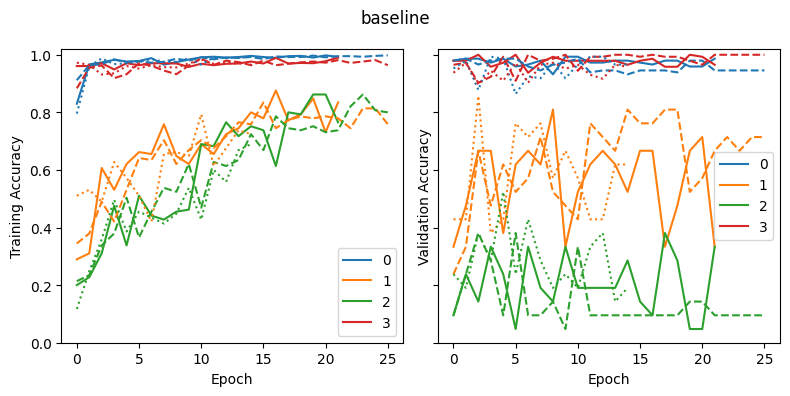

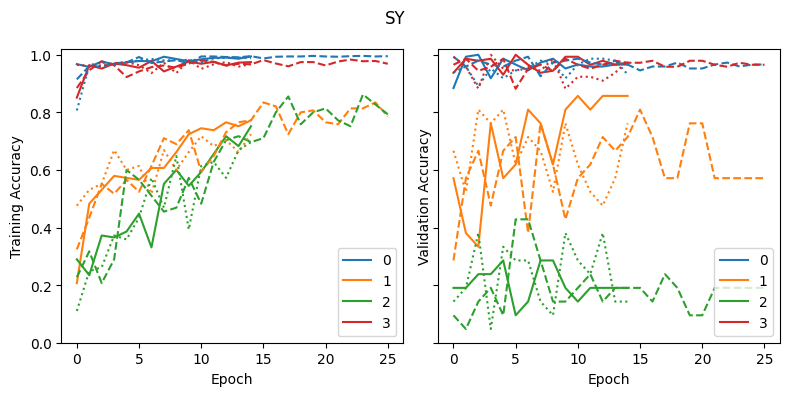

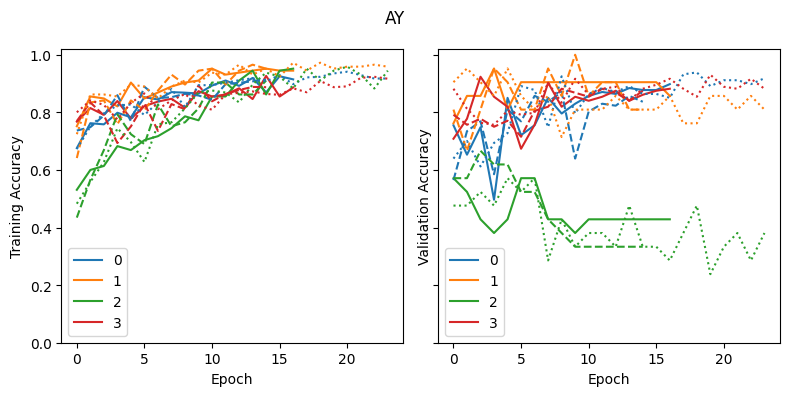

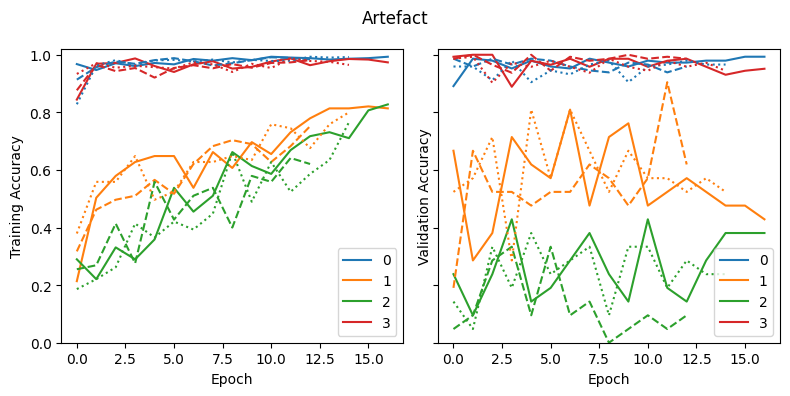

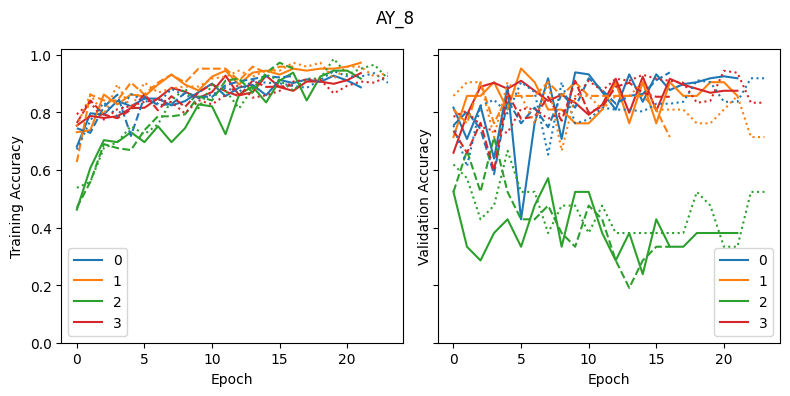

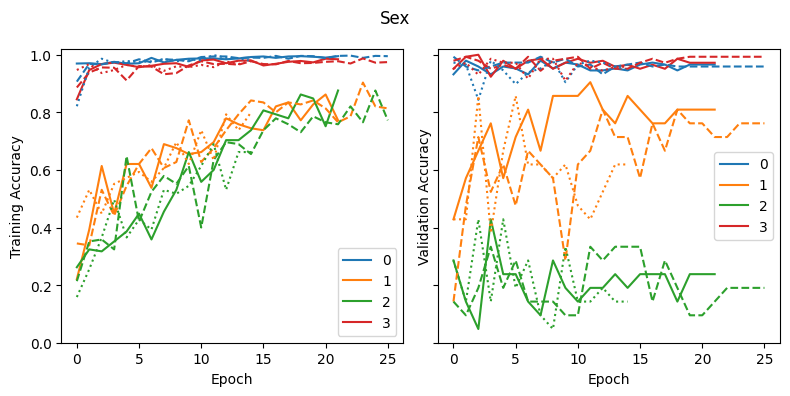

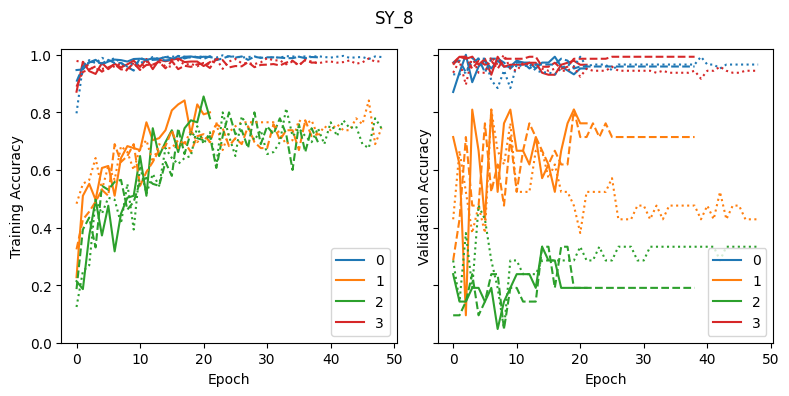

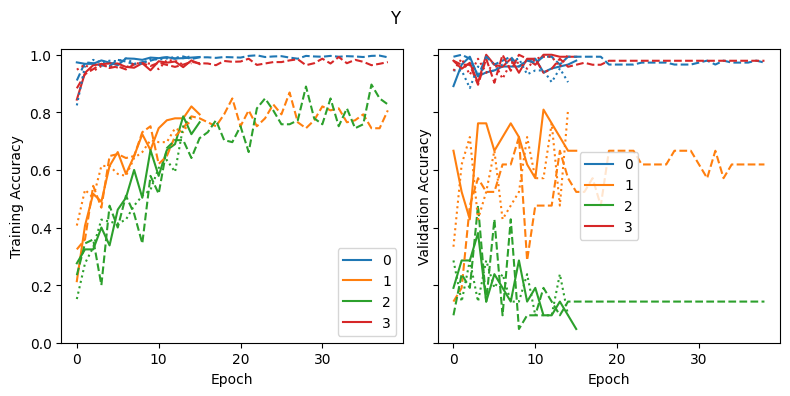

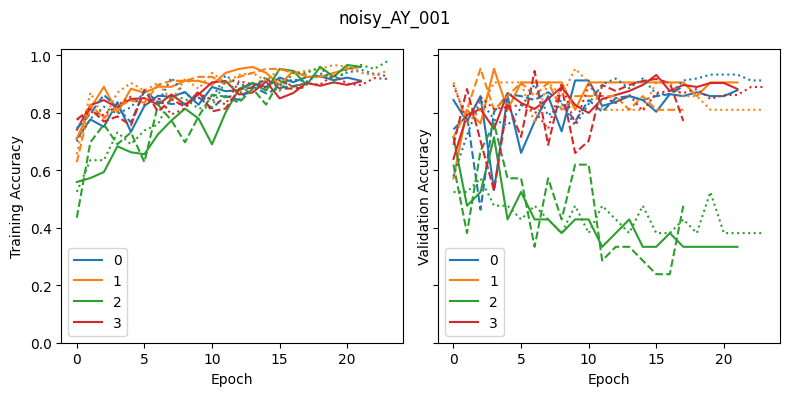

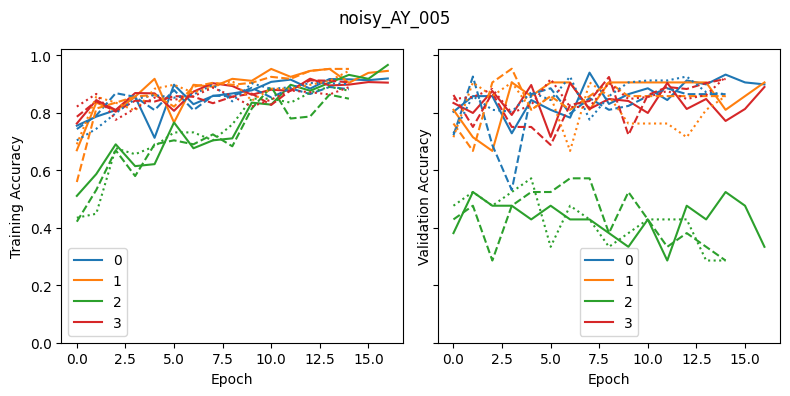

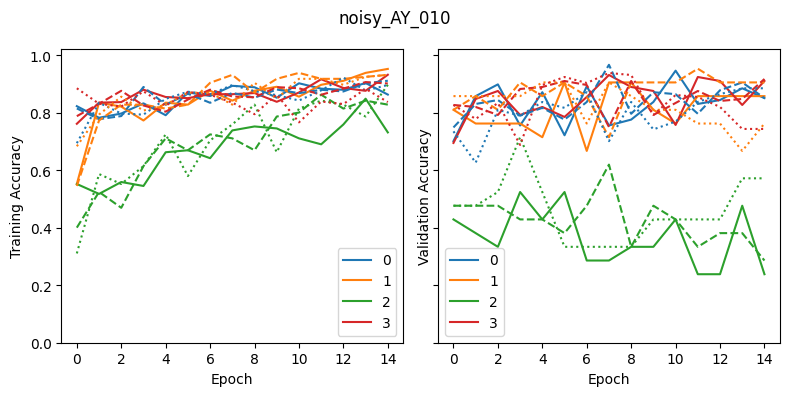

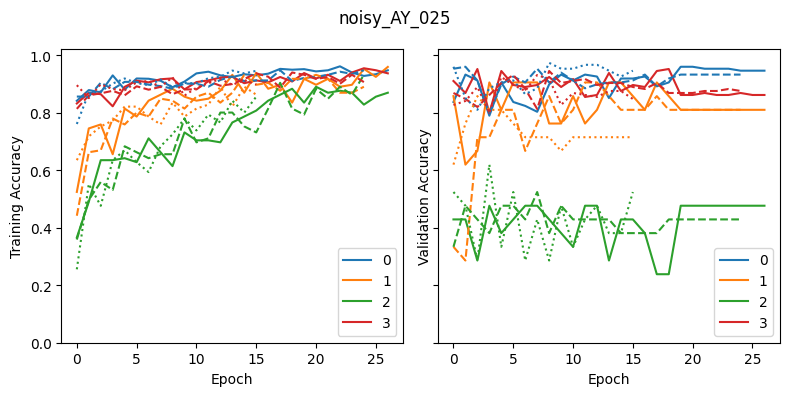

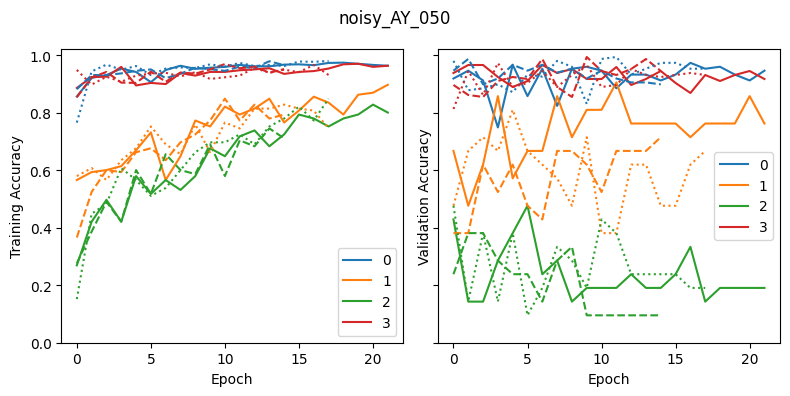

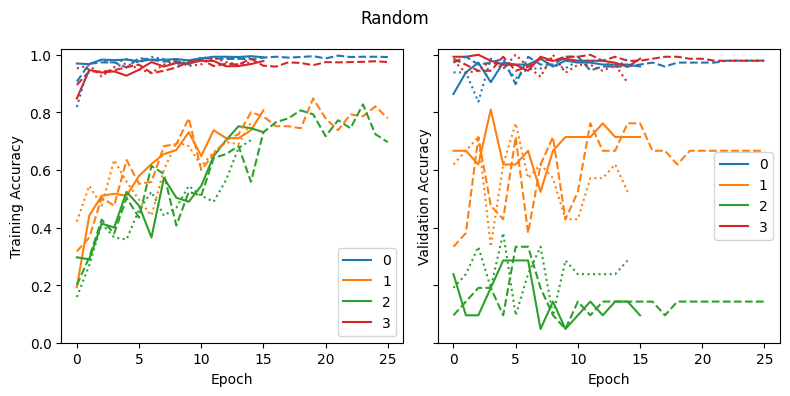

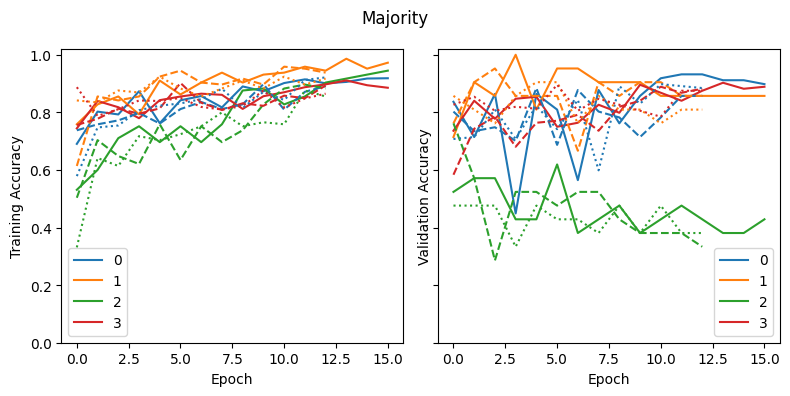

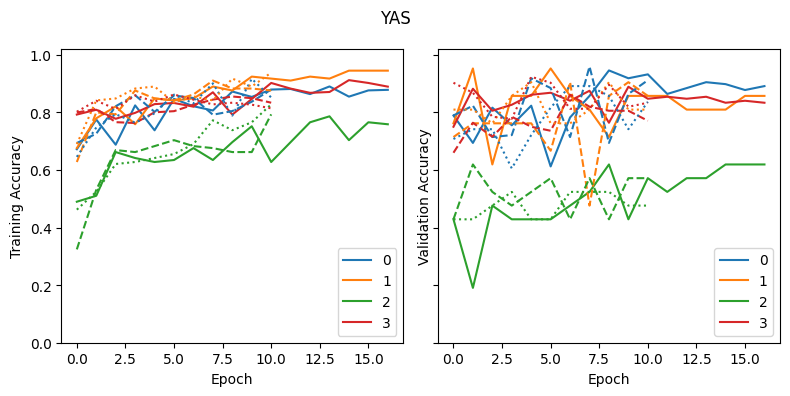

In [104]:
subgroup = 'AY' # can change this
experiments = test_results_dict.keys()
for experiment in experiments:
    train_preds_dict,val_preds_dict = train_val_dict[experiment],train_val_dict[experiment]
    plot_subgroup_acc(train_preds_dict,val_preds_dict, subgroup,plot_gap=False,plot_auc=False,plot_all=True,title = experiment,multiple_random_seeds=True)


# Loss

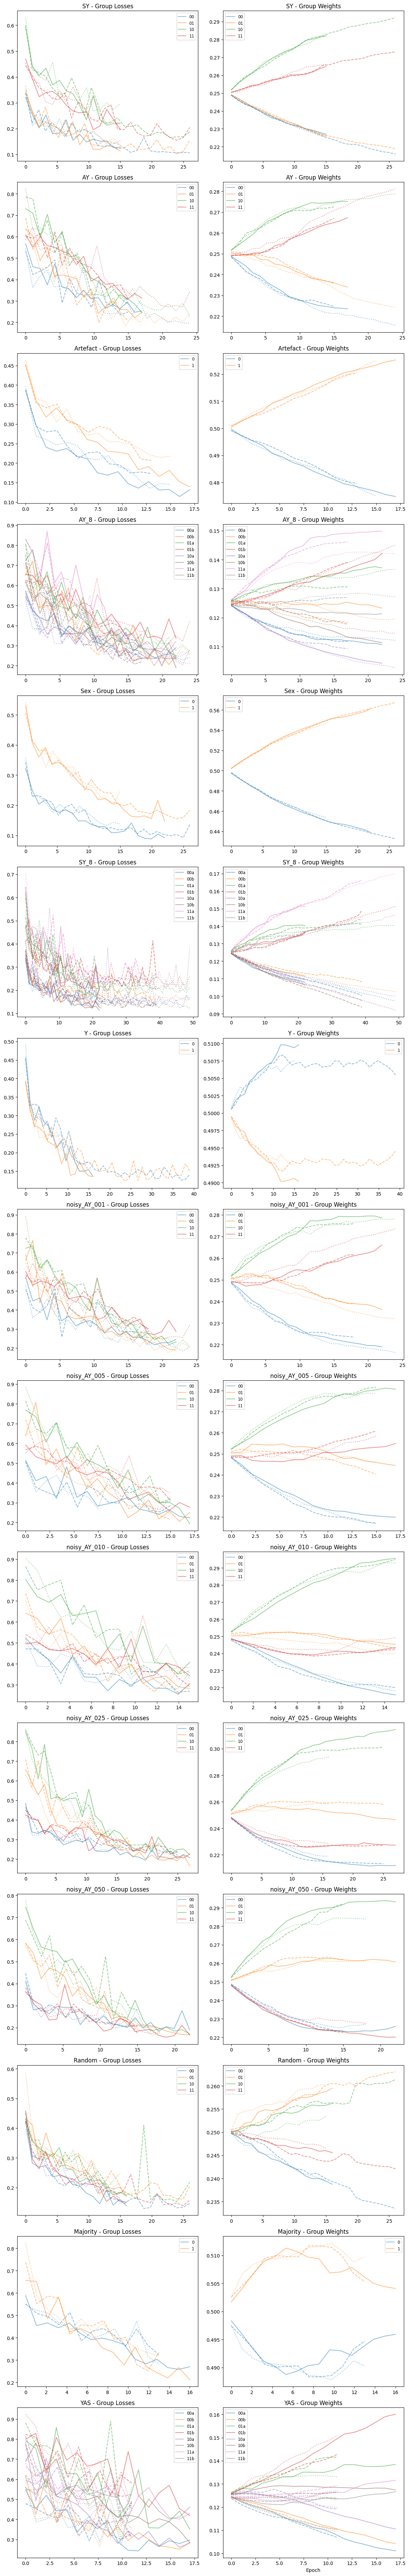

In [105]:
linestyles = ['-', '--', ':', '-.', ':']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

n_rows = len(loss_dict.keys())
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 5 * n_rows))

for row, experiment in enumerate(loss_dict.keys()):
    for i, random_seed in enumerate(loss_dict[experiment].keys()):
        mean_losses = loss_dict[experiment][random_seed]['mean_losses']
        dro_losses = loss_dict[experiment][random_seed]['losses']
        group_losses = loss_dict[experiment][random_seed]['group_losses']
        weights = loss_dict[experiment][random_seed]['weights']

        x = np.linspace(0, len(mean_losses), len(mean_losses))

        # Plot group losses
        ax1 = axes[row, 0]
        ax1.set_prop_cycle(color=colors)
        ax1.plot(x,group_losses,alpha = 0.5,linestyle=linestyles[i])
        plt.xlabel('Epoch')
        #plt.ylim(0.3,1)
        if len(group_losses[0]) == 4:
            ax1.legend(['00','01','10','11'],fontsize='small')
        if len(group_losses[0]) == 2:
            ax1.legend(['0','1'],fontsize='small')
        if len(group_losses[0]) == 8:
            ax1.legend(['00a','00b','01a','01b','10a','10b','11a','11b'],fontsize='small')

        # Plot group losses
        ax2 = axes[row, 1]
        ax2.set_prop_cycle(color=colors)
        ax2.plot(x,weights,alpha = 0.5,linestyle=linestyles[i])
        plt.xlabel('Epoch')
        #plt.ylim(0.3,1)
        if len(group_losses[0]) == 4:
            ax2.legend(['00','01','10','11'],fontsize='small')
        if len(group_losses[0]) == 2:
            ax2.legend(['0','1'],fontsize='small')
        if len(group_losses[0]) == 8:
            ax2.legend(['00a','00b','01a','01b','10a','10b','11a','11b'],fontsize='small')
       
    axes[row, 0].set_title(f'{experiment} - Group Losses')
    axes[row, 1].set_title(f'{experiment} - Group Weights')

plt.tight_layout()
plt.show()

# Specific investigation on noise

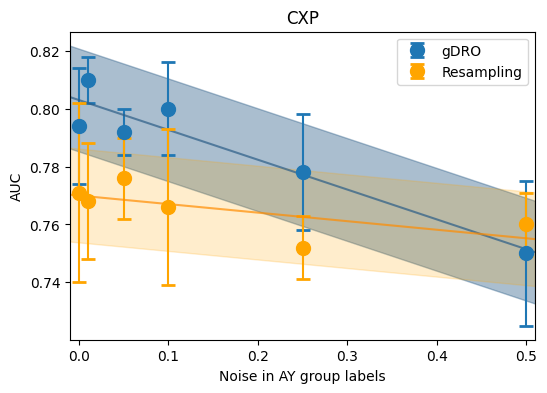

In [106]:
# gDRO
noise_overall_test_results = overall_results_df.loc[['AY','noisy_AY_001','noisy_AY_005','noisy_AY_010','noisy_AY_025','noisy_AY_050']]
noise_overall_std_test_results = overall_std_df.loc[['AY','noisy_AY_001','noisy_AY_005','noisy_AY_010','noisy_AY_025','noisy_AY_050']]

# rename index
noise_overall_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_std_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_test_results.index.name = 'Noise in AY groups'

x1 = noise_overall_test_results.index.values
y1 = noise_overall_test_results['AUC']
yerr1 = noise_overall_std_test_results['AUC']

plt.figure(figsize=(6, 4))

plt.errorbar(
    x1, y1, yerr=yerr1,
    fmt='o', markersize=10, capsize=5, capthick=2, label='gDRO'
)

slope1, intercept1, _, _, std_err1 = linregress(x1, y1)
line_x1 = np.linspace(min(x1)-0.01, max(x1)+0.01, 100)
line_y1 = slope1 * line_x1 + intercept1
stderr_fit1 = std_err1 * 1  # Adjusted CI margin
line_y_lower1 = line_y1 - stderr_fit1
line_y_upper1 = line_y1 + stderr_fit1

plt.plot(line_x1, line_y1, color='#2b5d87', alpha=0.7)
plt.fill_between(line_x1, line_y_lower1, line_y_upper1, alpha=0.4, color='#2b5d87')

# RESAMPLING
noise_overall_test_results = resampling_overall_results_df.loc[['AY','noisy_AY_001','noisy_AY_005','noisy_AY_010','noisy_AY_025','noisy_AY_050']]
noise_overall_std_test_results = resampling_overall_std_df.loc[['AY','noisy_AY_001','noisy_AY_005','noisy_AY_010','noisy_AY_025','noisy_AY_050']]

# rename index
noise_overall_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_std_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_test_results.index.name = 'Noise in AY groups'

x2 = noise_overall_test_results.index.values
y2 = noise_overall_test_results['AUC']
yerr2 = noise_overall_std_test_results['AUC']

plt.errorbar(
    x2, y2, yerr=yerr2,
    fmt='o', markersize=10, capsize=5, capthick=2, label='Resampling', color='orange'
)

slope2, intercept2, _, _, std_err2 = linregress(x2, y2)
line_x2 = np.linspace(min(x2)-0.01, max(x2)+0.01, 100)
line_y2 = slope2 * line_x2 + intercept2
stderr_fit2 = std_err2 * 1  # Adjusted CI margin
line_y_lower2 = line_y2 - stderr_fit2
line_y_upper2 = line_y2 + stderr_fit2

plt.plot(line_x2, line_y2, color='darkorange', alpha=0.7)
plt.fill_between(line_x2, line_y_lower2, line_y_upper2, alpha=0.2, color='orange')

# Customize the plot
plt.xlabel('Noise in AY group labels')
plt.ylabel('AUC')
plt.xlim(-0.01, 0.51)
plt.legend()
plt.title('CXP')
plt.show()


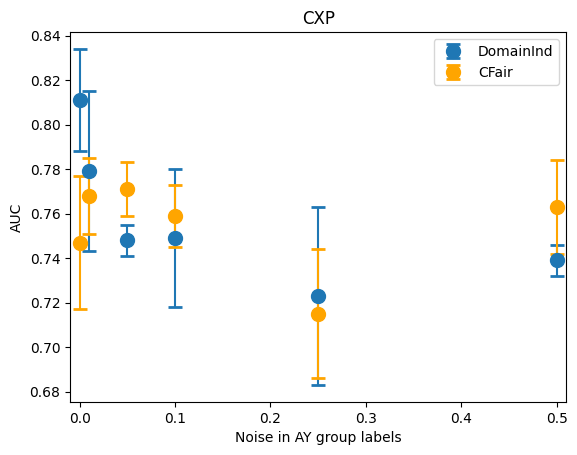

In [107]:
# DomainInd
noise_overall_test_results = DomainInd_overall_results_df.loc[['Artefact','noisy_A_001','noisy_A_005','noisy_A_010','noisy_A_025','noisy_A_050']]
noise_overall_std_test_results = DomainInd_overall_std_df.loc[['Artefact','noisy_A_001','noisy_A_005','noisy_A_010','noisy_A_025','noisy_A_050']]

# rename index
noise_overall_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_std_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_test_results.index.name = 'Noise in AY groups'

x1 = noise_overall_test_results.index.values
y1 = noise_overall_test_results['AUC']
yerr1 = noise_overall_std_test_results['AUC']

plt.errorbar(
    x1, y1, yerr=yerr1,
    fmt='o', markersize=10, capsize=5, capthick=2, label='DomainInd'
)

slope1, intercept1, _, _, std_err1 = linregress(x1, y1)
line_x1 = np.linspace(min(x1)-0.01, max(x1)+0.01, 100)
line_y1 = slope1 * line_x1 + intercept1
stderr_fit1 = std_err1 * 1  # Adjusted CI margin
line_y_lower1 = line_y1 - stderr_fit1
line_y_upper1 = line_y1 + stderr_fit1

# plt.plot(line_x1, line_y1, color='#2b5d87', alpha=0.7)
# plt.fill_between(line_x1, line_y_lower1, line_y_upper1, alpha=0.4, color='#2b5d87')

# CFair
noise_overall_test_results = cfair_overall_results_df.loc[['Artefact','noisy_A_001','noisy_A_005','noisy_A_010','noisy_A_025','noisy_A_050']]
noise_overall_std_test_results = cfair_overall_std_df.loc[['Artefact','noisy_A_001','noisy_A_005','noisy_A_010','noisy_A_025','noisy_A_050']]

# rename index
noise_overall_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_std_test_results.index = [0,0.01,0.05,0.1,0.25,0.5]
noise_overall_test_results.index.name = 'Noise in AY groups'

x2 = noise_overall_test_results.index.values
y2 = noise_overall_test_results['AUC']
yerr2 = noise_overall_std_test_results['AUC']

plt.errorbar(
    x2, y2, yerr=yerr2,
    fmt='o', markersize=10, capsize=5, capthick=2, label='CFair', color='orange'
)

slope2, intercept2, _, _, std_err2 = linregress(x2, y2)
line_x2 = np.linspace(min(x2)-0.01, max(x2)+0.01, 100)
line_y2 = slope2 * line_x2 + intercept2
stderr_fit2 = std_err2 * 1  # Adjusted CI margin
line_y_lower2 = line_y2 - stderr_fit2
line_y_upper2 = line_y2 + stderr_fit2

# plt.plot(line_x2, line_y2, color='darkorange', alpha=0.7)
# plt.fill_between(line_x2, line_y_lower2, line_y_upper2, alpha=0.2, color='orange')

# Customize the plot
plt.xlabel('Noise in AY group labels')
plt.ylabel('AUC')
plt.xlim(-0.01, 0.51)
plt.legend()
plt.title('CXP')
plt.show()


# Correlate performance with distance from P_test

In [108]:
subgroups_calculated = ['SY','AY','Artefact','AY_8','Sex','SY_8','Y','Random','Majority','YAS','noisy_AY_001','noisy_AY_005','noisy_AY_010','noisy_AY_025','noisy_AY_050'] # coudl add baseline with 0.38
P_test_distance_gdro = [0.375,0.129,0.295,0.129,0.375,0.375,0.295,0.375,0.17,0,0.129,0.13,0.131,0.135,0.141]
P_test_distance_resampling = [0.375,0.129,0.375,0.129,0.375,0.375,0.375,0.375,0.17,0,0.129,0.13,0.161,0.210,0.289] # p_test distance is slightly different for resampling


p_test_distance_gdro_df = pd.DataFrame(P_test_distance_gdro,index=subgroups_calculated,columns=['P_test_distance'])
p_test_distance_resampling_df = pd.DataFrame(P_test_distance_resampling,index=subgroups_calculated,columns=['P_test_distance'])

resampling_results_p_test = pd.merge(resampling_overall_results_df,p_test_distance_resampling_df,left_index=True,right_index=True)
resampling_results_p_test['AUC std'] = resampling_overall_std_df['AUC']
resampling_results_p_test['Accuracy std'] = resampling_overall_std_df['Accuracy']

gdro_results_p_test = pd.merge(overall_results_df,p_test_distance_gdro_df,left_index=True,right_index=True)
gdro_results_p_test['AUC std'] = overall_std_df['AUC']
gdro_results_p_test['Accuracy std'] = overall_std_df['Accuracy']

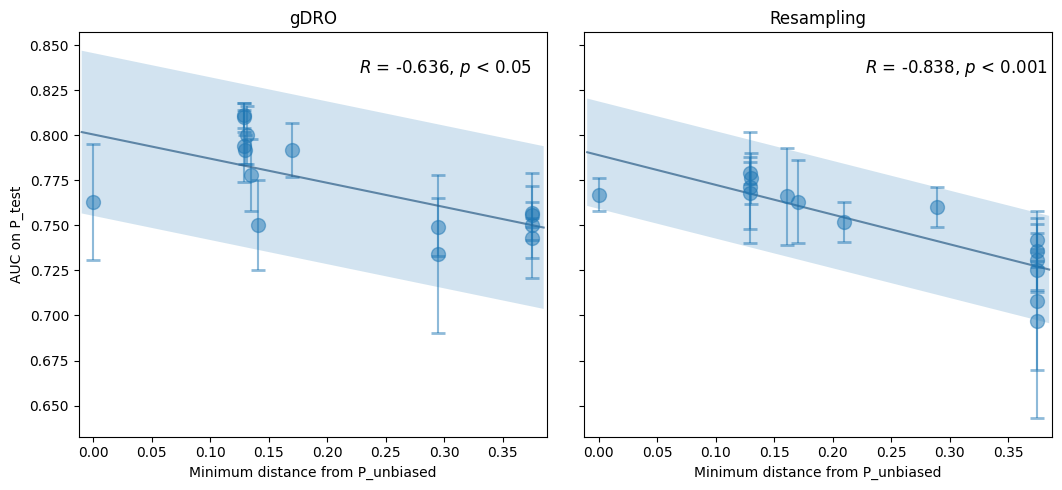

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharey=True)

axes[0].errorbar(
    gdro_results_p_test['P_test_distance'],
    gdro_results_p_test['AUC'],
    yerr=gdro_results_p_test['AUC std'],
    fmt='o',
    markersize=10,
    capsize=5,
    capthick=2,
    alpha=0.5
)
slope, intercept, r_value, p_value, std_err = linregress(gdro_results_p_test['P_test_distance'], gdro_results_p_test['AUC'])
line_x = np.linspace(min(gdro_results_p_test['P_test_distance'])-0.01, max(gdro_results_p_test['P_test_distance'])+0.01, 100)
line_y = slope * line_x + intercept
stderr_fit = gdro_results_p_test['AUC std'].std()  # Approximation for confidence interval width
line_y_lower = line_y - std_err
line_y_upper = line_y + std_err
axes[0].plot(line_x, line_y, label='Best fit line', color='#2b5d87', alpha=0.7)
axes[0].fill_between(line_x, line_y_lower, line_y_upper, alpha=0.2, label='95% CI')

# Compute and add Pearson correlation coefficient (ρ)
if p_value < 0.001:
    axes[0].text(0.6, 0.9, f"$R$ = {r_value:.3f}, $p$ < {0.001}", transform=axes[0].transAxes, fontsize=12) 
elif p_value < 0.05:
    axes[0].text(0.6, 0.9, f"$R$ = {r_value:.3f}, $p$ < {0.05}", transform=axes[0].transAxes, fontsize=12) 


axes[0].set_title("gDRO")
axes[0].set_xlabel("Minimum distance from P_unbiased")
axes[0].set_ylabel("AUC on P_test")
axes[0].set_xlim(-0.0125, 0.3875)

axes[1].errorbar(
    resampling_results_p_test['P_test_distance'],
    resampling_results_p_test['AUC'],
    yerr=resampling_results_p_test['AUC std'],
    fmt='o',
    markersize=10,
    capsize=5,
    capthick=2,
    alpha=0.5
)
slope, intercept, r_value, p_value, std_err = linregress(resampling_results_p_test['P_test_distance'], resampling_results_p_test['AUC'])
line_x = np.linspace(min(resampling_results_p_test['P_test_distance'])-0.01, max(resampling_results_p_test['P_test_distance'])+0.01, 100)
line_y = slope * line_x + intercept
stderr_fit = resampling_results_p_test['AUC std'].std()  # Approximation for confidence interval width
line_y_lower = line_y - std_err
line_y_upper = line_y + std_err
axes[1].plot(line_x, line_y, label='Best fit line', color='#2b5d87', alpha=0.7)
axes[1].fill_between(line_x, line_y_lower, line_y_upper, alpha=0.2, label='95% CI')

# Compute and add Pearson correlation coefficient (ρ)
if p_value < 0.001:
    axes[1].text(0.6, 0.9, f"$R$ = {r_value:.3f}, $p$ < {0.001}", transform=axes[1].transAxes, fontsize=12) 

axes[1].set_title("Resampling")
axes[1].set_xlabel("Minimum distance from P_unbiased")
axes[1].set_xlim(-0.0125, 0.3875)

plt.tight_layout()
plt.show()
